In [1]:
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''Load data'''
lines = open('./train.txt', encoding='utf-8').read().strip().split('\n')
tense=['sp','tp','pg','past']
input_txt=[]
tense_list=[]
target=[]
for line in lines:
    for i in range(3):
        for j in range(i+1,4):
            temp=line.split(' ')[i]+"_"+tense[j]+"_"+line.split(' ')[j]
            new_word=[[],[],[]]
            for h in temp.split('_')[0]:
                new_word[0].append(h)
            new_word[1].append(temp.split('_')[1])
            for h in temp.split('_')[2]:
                new_word[2].append(h)
            input_txt.append(new_word[0])
            tense_list.append(new_word[1])
            target.append(new_word[2])
            
            temp=line.split(' ')[j]+"_"+tense[i]+"_"+line.split(' ')[i]
            new_word=[[],[],[]]
            for h in temp.split('_')[0]:
                new_word[0].append(h)
            new_word[1].append(temp.split('_')[1])
            for h in temp.split('_')[2]:
                new_word[2].append(h)
            input_txt.append(new_word[0])
            tense_list.append(new_word[1])
            target.append(new_word[2])
            
max_len=17
print(input_txt[:5],target[:5])

en_idx=['sos','eos','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u'
        ,'v','w','x','y','z','sp','tp','pg','past']

input_tensors=torch.ones(len(input_txt),max_len, device=device,dtype =int)
target_tensors=torch.ones(len(target),max_len,1, device=device,dtype =int)
input_tensors[:,0]=0
target_tensors[:,0]=0

for i in range(len(input_txt)):
    for s in range(len(input_txt[i])):
        input_tensors[i,s+1]=en_idx.index(input_txt[i][s])
    input_tensors[i,len(input_txt[i])+1]=en_idx.index(tense_list[i][0])
    for s in range(len(target[i])):
        target_tensors[i,s+1,0]=en_idx.index(target[i][s])
        
print(input_tensors[:5],target_tensors[:5])

[['a', 'b', 'a', 'n', 'd', 'o', 'n'], ['a', 'b', 'a', 'n', 'd', 'o', 'n', 's'], ['a', 'b', 'a', 'n', 'd', 'o', 'n'], ['a', 'b', 'a', 'n', 'd', 'o', 'n', 'i', 'n', 'g'], ['a', 'b', 'a', 'n', 'd', 'o', 'n']] [['a', 'b', 'a', 'n', 'd', 'o', 'n', 's'], ['a', 'b', 'a', 'n', 'd', 'o', 'n'], ['a', 'b', 'a', 'n', 'd', 'o', 'n', 'i', 'n', 'g'], ['a', 'b', 'a', 'n', 'd', 'o', 'n'], ['a', 'b', 'a', 'n', 'd', 'o', 'n', 'e', 'd']]
tensor([[ 0,  2,  3,  2, 15,  5, 16, 15, 29,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  2,  3,  2, 15,  5, 16, 15, 20, 28,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  2,  3,  2, 15,  5, 16, 15, 30,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 0,  2,  3,  2, 15,  5, 16, 15, 10, 15,  8, 28,  1,  1,  1,  1,  1],
        [ 0,  2,  3,  2, 15,  5, 16, 15, 31,  1,  1,  1,  1,  1,  1,  1,  1]]) tensor([[[ 0],
         [ 2],
         [ 3],
         [ 2],
         [15],
         [ 5],
         [16],
         [15],
         [20],
         [ 1],
         [ 1],
         [ 1],
       

In [3]:
# SOS_token = 0
# EOS_token = 1
#----------Hyper Parameters----------#
hidden_size = 256
#The number of vocabulary
vocab_size = 32
teacher_forcing_ratio = 1.0
empty_input_ratio = 0.1
KLD_weight = -0.5
LR = 0.0001

epochs=10
KLD_weight_list=[0.]*epochs
total_loss=[0.]*epochs
crossentropy=[0.]*epochs
BLEU_score=[0.]*epochs
KLD_cost_list=[0.]*epochs

#Encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, max_len, -1)
        output = embedded
        output, (encoder_hidden,encoder_cell) = self.lstm(output,(hidden,hidden))
        return output, encoder_hidden, encoder_cell

    def initHidden(self):
        return torch.zeros(1, max_len, self.hidden_size, device=device)

#Decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        output = self.embedding(input).view(1, max_len, -1)
        output = F.relu(output)
        output, (decoder_hidden,decoder_cell) = self.lstm(output,(hidden,cell))
        output = self.out(output[0])
        return output, decoder_hidden, decoder_cell

    def initHidden(self):
        return torch.zeros(1, max_len, self.hidden_size, device=device)


#  Reparameterization   
def reparameterize(mu, logvar):
    std = logvar.mul(0.5).exp_()
    latent = mu + std 
    return latent

# Kullback–Leibler divergence loss
def loss_fn( mu, logvar,epoch):
    KLD_weight=(epoch+1)/20
    KLD_weight_list[epoch]=KLD_weight
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    KLD_cost_list[epoch]+=KLD_weight*KLD/max_len
    return KLD_weight*KLD


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, epoch):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    #----------sequence to sequence part for encoder----------#
    encoder_output, encoder_hidden, encoder_cell= encoder(input_tensor, encoder_hidden)
    # Hidden and cell latent
    hidden_latent = reparameterize(encoder_hidden,encoder_hidden)
    cell_latent = reparameterize(encoder_cell,encoder_cell)

    decoder_input = target_tensor  #Input answer for decoder when loss high
    decoder_hidden = hidden_latent
    decoder_cell = cell_latent
    
    #Use teacher forcing if epoch > 5
    use_teacher_forcing = True if epoch < 5 else False


    #----------sequence to sequence part for decoder----------#
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        decoder_output, decoder_hidden,decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
        KLD_cost=loss_fn(encoder_hidden,decoder_cell,epoch)
        
        for i in range(max_len):
            crossentropy[epoch]+=criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])/(14724*max_len) #14724 words after tense
            loss += criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])+KLD_cost

    else:
        # Without teacher forcing: use its own predictions as the next input
        decoder_output, decoder_hidden,decoder_cell = decoder(decoder_input, decoder_hidden, decoder_cell)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()  

        KLD_cost=loss_fn(encoder_hidden,decoder_cell,epoch)
        for i in range(max_len):
            crossentropy[epoch]+=criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])/(14724*max_len)  #14724 words after tense
            loss += criterion(decoder_output[i].view(-1,vocab_size), target_tensor[i])
#         print(crossentropy[epoch],epoch)
        loss+=KLD_cost


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length




def trainIters(encoder, decoder, n_iters, learning_rate=LR):
    start = time.time()
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=LR)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=LR)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(n_iters):
        for i in range(14724):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]

            loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion, epoch)
            total_loss[epoch]+=loss

        print("epoch : " , epoch , ", loss : " , round(total_loss[epoch]/14724,4))
        outputs=evaluate(encoder1,decoder1,epoch,show_result=True)

In [4]:
def compute_bleu(output, reference):
    cc = SmoothingFunction()
    if len(reference) == 3:
        weights = (0.33,0.33,0.33)
    else:
        weights = (0.25,0.25,0.25,0.25)
    return sentence_bleu([reference], output,weights=weights,smoothing_function=cc.method1)

def evaluate(encoder, decoder, epoch, show_result=False):
    inputs=['abandon','abet','begin','expend','sent','split','flared','functioning','functioning','healing']
    input_tense=['past','pg','tp','tp','tp','pg','sp','sp','past','tp']
    reference=['abandoned','abetting','begins','expends','sends','splitting','flare','function','functioned','heals']
    test_input_tensors=torch.ones(10,max_len, device=device,dtype =int)
    test_target_tensors=torch.ones(10,max_len,1, device=device,dtype =int)
    test_input_tensors[:,0]=0
    test_target_tensors[:,0]=0

    cnt1=0
    for i in inputs:
        cnt2=1
        for j in i:
            test_input_tensors[cnt1,cnt2]=en_idx.index(j)
            cnt2+=1
        test_input_tensors[cnt1,cnt2]=en_idx.index(input_tense[cnt1])
        cnt1+=1

    outputs=[]
    if (show_result):
        print("Tense conversion:")
    for i in range(10):
        output=''
        input_tensor=test_input_tensors[i]
        target_tensor=test_target_tensors[i]
        
        encoder_hidden = encoder.initHidden()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)

        encoder_output, encoder_hidden, encoder_cell= encoder(input_tensor, encoder_hidden)

        # Hidden and cell latent
        hidden_latent = reparameterize(encoder_hidden,encoder_hidden)
        cell_latent = reparameterize(encoder_cell,encoder_cell)

        decoder_input = input_tensor
        decoder_hidden = hidden_latent
        decoder_cell = cell_latent

        for di in range(1,target_length):
            decoder_output, decoder_hidden ,decoder_cell= decoder(decoder_input, decoder_hidden,decoder_cell)
            pre_idx=torch.argmax(decoder_output[di],axis=0)
            if en_idx[pre_idx.item()]!='eos' and en_idx[pre_idx.item()]!='sos':
                output=output+en_idx[pre_idx.item()]
        if (show_result):
            print("Input: {:12}".format(inputs[i]),"  Target: {:12}".format(reference[i]),"  Prediction: {:12}".format(output))
      
        outputs.append(output)

    score=0
    for i in range(10):
        score+=compute_bleu(outputs[i],reference[i])
    BLEU_score[epoch]=score/10
    print("BLEU-4 score: ",round(score/10,4))
    return [outputs]


In [5]:
#Training

encoder1 = EncoderRNN(vocab_size, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, vocab_size).to(device)
trainIters(encoder1, decoder1, epochs)

epoch :  0 , loss :  0.5521
Tense conversion:
Input: abandon        Target: abandoned      Prediction: abandon     
Input: abet           Target: abetting       Prediction: abete       
Input: begin          Target: begins         Prediction: begin       
Input: expend         Target: expends        Prediction: expend      
Input: sent           Target: sends          Prediction: sent        
Input: split          Target: splitting      Prediction: splite      
Input: flared         Target: flare          Prediction: flared      
Input: functioning    Target: function       Prediction: functioning 
Input: functioning    Target: functioned     Prediction: functioning 
Input: healing        Target: heals          Prediction: healing     
BLEU-4 score:  0.6083
epoch :  1 , loss :  0.0859
Tense conversion:
Input: abandon        Target: abandoned      Prediction: abandon     
Input: abet           Target: abetting       Prediction: abete       
Input: begin          Target: begins         P

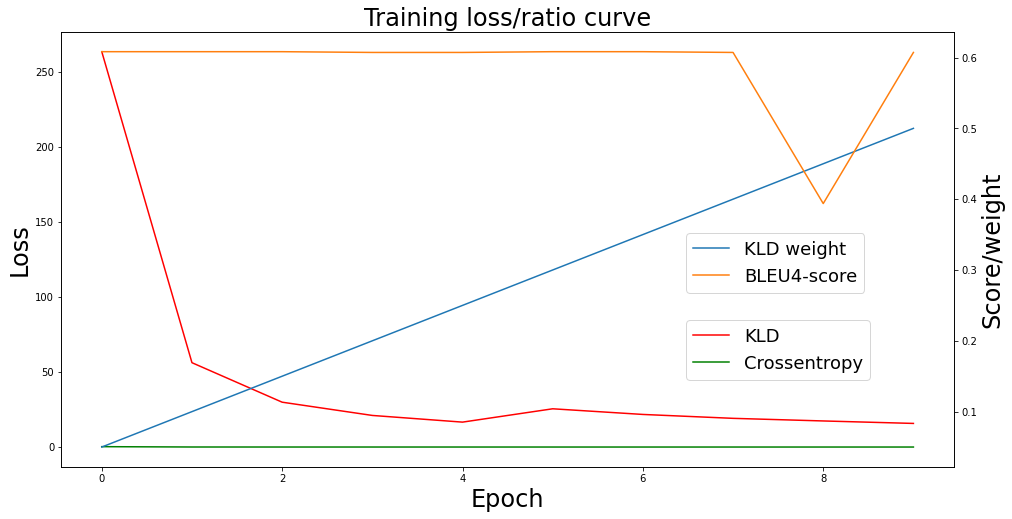

In [6]:
#Plot result

fig, ax1 = plt.subplots(figsize=(16,8))

plt.title("Training loss/ratio curve",fontsize=24) 
ax1.set_ylabel("Loss",fontsize=24) 
plt.xlabel("Epoch",fontsize=24)
ax1.plot(range(10),KLD_cost_list,color="red")
ax1.plot(range(10),crossentropy,color="green")

ax2 = ax1.twinx()
ax2.set_ylabel("Score/weight",fontsize=24) 
ax2.plot(range(10),KLD_weight_list)
ax2.plot(range(10),BLEU_score)
ax1.legend(["KLD","Crossentropy"], loc= {0.7,0.2},fontsize=18)
ax2.legend(["KLD weight","BLEU4-score"], loc={0.7,0.4},fontsize=18)
# plt.savefig('./conversion_2.jpg',dpi=300)
plt.show()

In [8]:
#Save model

# torch.save(encoder1, './encoder_conversion.pt')
# torch.save(decoder1, './decoder_conversion.pt')

In [5]:
#Load model and predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder1=torch.load('encoder_conversion.pt').to(device)
decoder1=torch.load('decoder_conversion.pt').to(device)
result=evaluate(encoder1,decoder1,1,show_result=True)

Tense conversion:
Input: abandon        Target: abandoned      Prediction: abandon     
Input: abet           Target: abetting       Prediction: abetg       
Input: begin          Target: begins         Prediction: begins      
Input: expend         Target: expends        Prediction: expends     
Input: sent           Target: sends          Prediction: sents       
Input: split          Target: splitting      Prediction: splitg      
Input: flared         Target: flare          Prediction: flared      
Input: functioning    Target: function       Prediction: functioning 
Input: functioning    Target: functioned     Prediction: functioning 
Input: healing        Target: heals          Prediction: healings    
BLEU-4 score:  0.639
